In [4]:
## Imports
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile as wv
import torch
import torch.nn as nn
from tqdm import tqdm # progress bar
from audioMNIST import AudioMNIST
from DClassifier import CNN2DAudioClassifier
from torch.utils.data import DataLoader, random_split

In [5]:
file_paths = './data/'

In [7]:
# module1 - Find least amount of iters needed
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Data split
def load_data_and_split(dataset):
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True, num_workers=4)
    all_features, all_labels = [], []

    for data, target in loader:
        all_features.append(data.numpy())
        all_labels.append(target.numpy())

    all_features = np.vstack(all_features).reshape(len(dataset), -1)
    all_labels = np.concatenate(all_labels)

    # 60 - 20 - 20
    X_train_val, X_test, y_train_val, y_test = train_test_split(all_features, all_labels, test_size=0.20, random_state=4400)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=4400)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Eval different iters
def train_and_evaluate(X_train, X_val, y_train, y_val):
    max_iters = [10, 20, 50, 100, 250, 290]
    results = []

    for iter in max_iters:
        lr = LogisticRegression(penalty='l2', max_iter=iter, solver='liblinear')
        lr.fit(X_train, y_train)
        y_val_pred = lr.predict(X_val)
        accuracy = metrics.accuracy_score(y_val, y_val_pred)
        f1 = metrics.f1_score(y_val, y_val_pred, average='macro')
        results.append((iter, accuracy, f1))
        print(f'{iter} iterations: Validation Accuracy = {accuracy}, Validation F1 Score = {f1}')

    return results

if __name__ == '__main__':
    dataset = AudioMNIST()
    X_train, X_val, X_test, y_train, y_val, y_test = load_data_and_split(dataset)
    train_and_evaluate(X_train, X_val, y_train, y_val)

"\n# module1 - Find least amount of iters needed\nimport numpy as np\nfrom torch.utils.data import DataLoader\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn import metrics\n\n# Data split\ndef load_data_and_split(dataset):\n    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True, num_workers=4)\n    all_features, all_labels = [], []\n\n    for data, target in loader:\n        all_features.append(data.numpy())\n        all_labels.append(target.numpy())\n\n    all_features = np.vstack(all_features).reshape(len(dataset), -1)\n    all_labels = np.concatenate(all_labels)\n\n    # 60 - 20 - 20\n    X_train_val, X_test, y_train_val, y_test = train_test_split(all_features, all_labels, test_size=0.20, random_state=4400)\n    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=4400)\n\n    return X_train, X_val, X_test, y_train, y_val, y_test\n\n# Eval dif

/Users/Yuhmmy/Desktop/ds4400/final_proj/space/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Yuhmmy/Desktop/ds4400/final_proj/space/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Yuhmmy/Desktop/ds4400/final_proj/space/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Yuhmmy/Desktop/ds4400/final_proj/space/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Yuhmmy/Desktop/ds4400/final_proj/space/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

Best C (1/lambda): {'C': 10}
Best cross-validation accuracy: 0.9196111111111112
Test Accuracy with best C: 0.9195, Test F1 Score: 0.9194140095456163


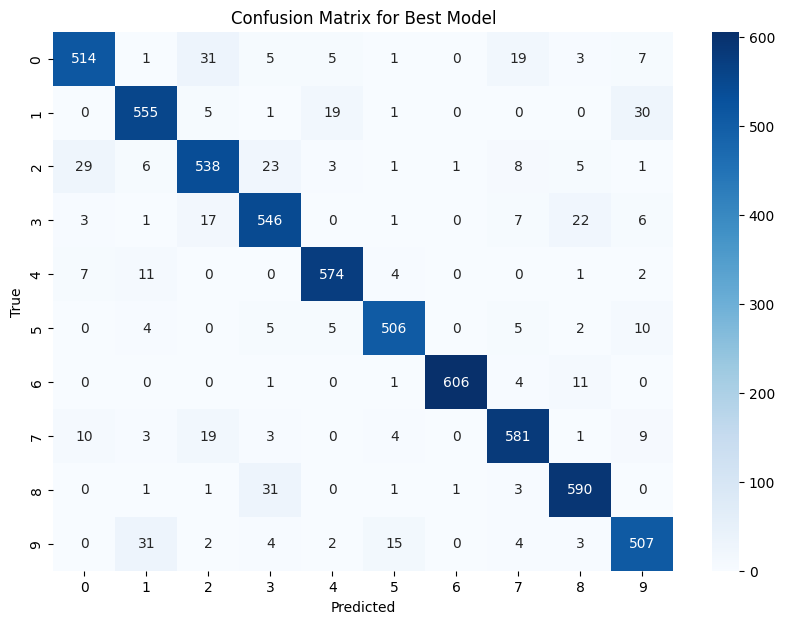

In [8]:
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

def load_data_and_split(dataset):
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True, num_workers=4)
    all_features, all_labels = [], []

    for data, target in loader:
        all_features.append(data.numpy())
        all_labels.append(target.numpy())

    # Preprocess and reshape data once instead of every load
    all_features = np.vstack(all_features).reshape(len(dataset), -1)
    all_labels = np.concatenate(all_labels)

    # Split the data
    X_train_val, X_test, y_train_val, y_test = train_test_split(all_features, all_labels, test_size=0.20, random_state=4400)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=4400)

    return X_train, X_val, X_test, y_train, y_val, y_test

def optimize_and_evaluate(X_train, X_test, y_train, y_test):
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    lr_model = LogisticRegression(penalty='l2', max_iter=100, solver='saga')
    grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best C (1/lambda):", grid_search.best_params_)
    print("Best cross-validation accuracy:", grid_search.best_score_)

    best_lr = grid_search.best_estimator_
    y_test_pred = best_lr.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    f1_score = metrics.f1_score(y_test, y_test_pred, average='macro')
    print(f'Test Accuracy with best C: {accuracy}, Test F1 Score: {f1_score}')

    cm = metrics.confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for Best Model')
    plt.show()

if __name__ == '__main__':
    dataset = AudioMNIST()
    X_train, X_val, X_test, y_train, y_val, y_test = load_data_and_split(dataset)
    optimize_and_evaluate(X_train, X_val, X_test, y_train, y_val, y_test)